# Recipe 2: Interpretability
## Overview 


Recipe `1-engine-intro.ipynb` provides a basic introduction to the Howso Engine 
workflow. In that notebook, we inspect model accuracy, but we don't investigate how the model makes its predictions. After building and training a Trainee, a user will want to explore how different features affect the Trainee and its predictions. In this notebook we will explore information that can be extracted from a Trainee. Howso Engine's interpretability tools allow users to understand why predictions were made, evaluate the data that contributed to the predictions, and learn which features are most impactful to the prediction. These Howso Engine interpretability capabilities will be demonstrated in this notebook:

- Feature Relevancy Metrics

- Case Influence Metrics

- Residuals and Conviction Metrics 

## Recipe Goals:
This recipe will demonstrate how to leverage Howso Engine's interpretability to help us understand an unintuitive prediction.

In [1]:
import os

import pandas as pd
import plotly.io as pio
from pmlb import fetch_data

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_feature_importances

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Train, Analyze, and React

The first part of this notebook will follow the same work as `1-engine-intro.ipynb`. We will be using the same `Adult` dataset where the Action Feature is a binary indicator of whether a person makes over $50k/year.

### Step 1: Load Data

In [2]:
df = fetch_data('adult', local_cache_dir="data/adult")

# Subsample the data to ensure the example runs quickly
df = df.sample(1000, random_state=0).reset_index(drop=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,41.0,4,151856.0,11,9.0,2,11,0,4,1,0.0,0.0,40.0,39,1
1,57.0,6,87584.0,10,16.0,0,10,1,4,0,0.0,0.0,25.0,39,1
2,31.0,2,220669.0,9,13.0,4,10,3,4,0,6849.0,0.0,40.0,39,1
3,55.0,4,171355.0,8,11.0,2,7,0,4,1,0.0,0.0,20.0,39,1
4,59.0,6,148626.0,0,6.0,2,5,0,4,1,0.0,0.0,40.0,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,29.0,4,166220.0,9,13.0,4,12,3,4,0,0.0,0.0,50.0,39,1
996,60.0,0,204486.0,9,13.0,2,0,0,4,1,0.0,0.0,8.0,39,0
997,48.0,2,93449.0,14,15.0,2,10,0,1,1,99999.0,0.0,40.0,30,0
998,25.0,4,114838.0,14,15.0,4,10,1,4,0,0.0,0.0,8.0,22,1


### Step 1a: Define Test Case

To demonstrate a basic situation where Howso Engine's interpretability can help the user understand and feel more comfortable with a prediction, we are artificially creating a troubling case that the user may feel the need to further investigate. We create a case where a person makes less than $50k, but set two columns `capital-gain` and `hours-per-week` to values at the extreme ends of their ranges in the dataset. Without knowing too much about the results, a logical hypothesis from the user would be that a person who has high capital gains and works a very high number of hours will likely earn over $50k, making the case unusual.

In [3]:
# Custom test case with high capital-gain and hours-per-week
data = {
    'age': [25],
    'workclass': [4],
    'fnlwgt': [100000],
    'education': [15],
    'education-num': [9],
    'marital-status': [1],
    'occupation': [3],
    'relationship': [2],
    'race': [4],
    'sex': [1],
    'capital-gain': [99999],
    'capital-loss': [0],
    'hours-per-week': [80],
    'native-country': [39],
    'target': [0]
}

test_case = pd.DataFrame(data)

### Step 2: Train

In [4]:
# Infer feature attributes
features = infer_feature_attributes(df)

# Specify Context and Action Features
action_features = ['target']
context_features = features.get_names(without=action_features)

# Create the Trainee
t = Trainee(
    features=features,
    overwrite_existing=True
)

# Train
t.train(df)

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

### Step 3: React with Details

To make a prediction on untrained data with a Trainee, we must use the `react` method of the Trainee. As long as we pass in data and specify both context and action features, the response from the Trainee will contain the predicted values we want. However, we will not get any of the desired interpretability information.

To request further information from the Trainee about how a prediction was made, the `details` parameter of `react` must be used. `details` takes a dictionary that can have a large variety of keys whose values specify the desired information that the Trainee should return alongside the prediction. To see more about available details, please see the [API documentation](https://docs.howso.com).

In [5]:
# Specify the set of details to request from the Trainee that will
# provide interpretability
details = {
    'feature_residuals': True,
    'robust_residuals': True,
    'local_case_feature_residual_convictions': True,
    'feature_contributions':True,
    'influential_cases': True
}

results = t.react(
    test_case[context_features],
    context_features=context_features,
    action_features=action_features,
    details=details
)

predictions = results['action'][action_features]

In [6]:
print(f"Actual Value - {test_case[action_features[0]][0]}")
print(f"Predicted Value - {predictions.iloc[0,0]}")

Actual Value - 0
Predicted Value - 0


### Step 4: Results

We can see that the predicted target value is 0, which is correct. However, in a scenario where this Trainee is used for real predictions where we do not know the actual value, we may feel uneasy about this prediction. In this situation, even if our Trainee has been demonstrated to be accurate for other cases, intuitively, it is hard to imagine someone who works 80 hours per week and has such high capital gains making under $50k. Although we should not immediately dismiss this result, it warrants further investigation to help us understand and feel more comfortable using the Trainee's prediction. 


# Section 2: Inspect Details

### Step 1: Feature Residuals

We have just seen a predicted case which may intuitively seem odd as two features `capital-gains` and `hours-per-week` have unusually high values, especially for a someone that is predicted to make less than $50k. First, we want to confirm our suspicions that these values are not typical by looking at `Feature Residuals`. Feature Residuals are the mean absolute error between predicted and true values for each feature. They are calculated by holding out each individual feature, and then using the rest of the features to predict that feature. This is similiar to the leave-one-out validation technique used in machine learning. The results represent the Trainee's uncertainty for that feature. We will use the `Local Feature Residuals` to examine the uncertainty for region of data around this case and the `Global Feature Residual` as a baseline as they represent the residual across the entire trained model.

### **Definitions:**

**`Residuals`:** The mean absolute error between the predicted and actual data point. A residual characterizes the Trainees's uncertainty. By default, Howso Engine computes robust residuals, meaning it measures the residuals of the Action Feature values as predicted by a sampling of the power set of all of the other features. Residuals computed using the leave-one-out approach are referred to as "full" residuals rather than "robust".

**`Local Feature Residuals`:** Represents the uncertainty for the localized model which is made up of the cases nearest to the predicted case.

**`Global Feature Residuals`:** Represents the uncertainty for the overall model.

In [7]:
# We use react on the cases in our trainee and cache the results with react_into_trainee
t.react_into_trainee(context_features=context_features, action_feature=action_features[0], contributions_robust=True, mda=True, residuals=True)

In [8]:
# Global Feature Residual
global_feature_residuals = t.get_prediction_stats(action_feature=action_features[0], stats=['mae'])
global_feature_residuals

,sex,education-num,hours-per-week,age,relationship,fnlwgt,capital-gain,marital-status,native-country,race,education,capital-loss,occupation,workclass
mae,0.286426,1.476578,7.547175,8.854149,0.386064,77422.625803,1562.197973,0.325924,0.15643,0.200009,0.615924,221.291692,0.830589,0.460276


In [9]:
# Local Feature Residual
feature_residuals_dicts = results['details']['feature_residuals']
feature_residuals = pd.DataFrame(list(feature_residuals_dicts[0].items()))
feature_residuals = feature_residuals.T
feature_residuals.columns = feature_residuals.loc[0]
feature_residuals = feature_residuals.drop(0, axis=0)
feature_residuals[list(global_feature_residuals.columns) + ['target']]

,sex,education-num,hours-per-week,age,relationship,fnlwgt,capital-gain,marital-status,native-country,race,education,capital-loss,occupation,workclass,target
1,0.337215,1.032943,14.871912,9.684283,0.368636,66948.337054,20435.051752,0.352487,0.15727,0.213151,0.564266,127.368654,0.872203,0.462335,0.227821


We can see that `capital-gain` and `hours-per-week` show high local residuals when compared to the global residuals, indicating that these features for our case have high uncertainty. This tells us that these two features are particularly noisy in this region of the data. In lay terms, when the rest of the features are used to predict these two features and the predictions are inaccurate, i.e., has higher residuals, then these two features are uncertain because they are not what the model expects given the values of the other features.

### Step 2: Feature Contributions

Now that we see these features are a bit unusual, we can determine how important they are. One metric that allows a user to gain insight into feature importance is Howso Engine's Feature Contribution. Feature Contribution gives the user insight into the magnitude of a feature's effect on the predicted outcome, regardless of accuracy.

### **Definitions:**

**`Feature Contribution`:** The difference between the predicted Action Feature value when a feature is used as a Context Feature and the predicted value when it is not used (all other Context Features are used). Feature Contribution units are on the same scale as the Action Feature(s), and will be probabilities for categorical features.

**`Robust Feature Contribution`:** The difference between the predicted Action Feature value(s) when each feature is used as a Context Feature and the predicted value when it is not used with the remaining Context features being a sampling of the power set of all of the Context features. This is closely related to the commonly used `SHAP` feature importance measure. The difference is that SHAP is an exact value for a model (which itself is an approximation) whereas Robust Feature Contribution is an approximation of the feature importance for the relationships expressed in the data.

/home/runner/.local/lib/python3.11/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



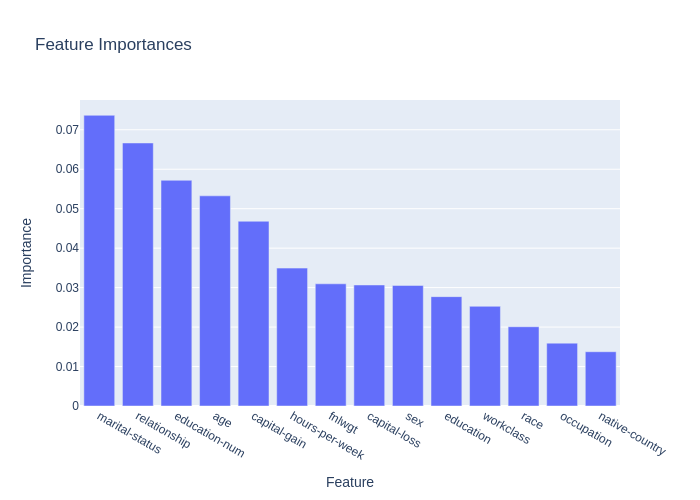

In [10]:
# Helper variable for graphing
num_features=10

# Robust Feature Contributions
robust_feature_contributions = t.get_prediction_stats(action_feature=action_features[0], stats=['contribution'])
fig = plot_feature_importances(robust_feature_contributions)
fig.show()


We can see that `capital-gain` and `hours-per-week` generally lie between the 4th and 8th most relevant features according to `feature_contributions`. While this shows that these two features are important in the Trainee and that our unusual feature values may still be concerning, they are still noticeably less important that the top 4 most important features. Intuitively, we expected a feature like `hours-per-week` to have a large impact on our prediction, however these results indicate that it may not have the strong effect we expected. This starts to give us more confidence in the results, as it is likely the most relevant features have values much more in line with someone who makes less than $50k. For example the person is 29 years old, which is quite young in this dataset. It is likely this young age had a large impact in the prediction as age is a strong contributor to the prediction of salary according to these results.

### Step 4: Influential Cases

One of Howso Engine's most powerful tools is the ability to tell the user which cases are used to derive a prediction. 


### **Definitions:**

**`Influential Cases`:** The set of cases used to derive a prediction. The Cases are returned with influence weights which represent the proportion of the influence that Case had on the result. The Influential Cases' weights sum to 1.

In [11]:
influence_df = pd.DataFrame(results['details']['influential_cases'][0])

influence_df

,sex,education-num,hours-per-week,age,relationship,fnlwgt,.influence_weight,target,capital-gain,.session,.session_training_index,marital-status,native-country,race,education,capital-loss,occupation,workclass
0,0,9,36,28,5,126060,0.064752,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,627,2,39,4,11,0,1,4
1,1,13,72,46,0,198660,0.064526,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,230,2,39,4,9,0,12,5
2,1,15,40,56,0,98418,0.059154,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,40,2,39,4,14,0,10,5
3,0,13,20,49,5,159816,0.057337,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,787,2,39,4,9,0,10,4
4,1,16,40,65,0,184965,0.055882,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,649,2,39,4,10,0,4,5
5,1,15,40,48,0,93449,0.050922,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,997,2,30,1,14,0,10,2
6,1,15,50,54,0,269068,0.047027,0,99999,4116ee7e-584c-453f-8aa5-497bf8b3d1df,556,2,30,1,14,0,10,6
7,1,10,60,23,0,109952,0.044438,1,0,4116ee7e-584c-453f-8aa5-497bf8b3d1df,123,2,39,4,15,0,3,4
8,1,10,55,26,0,94477,0.044036,0,7298,4116ee7e-584c-453f-8aa5-497bf8b3d1df,863,2,39,4,15,0,14,4
9,1,9,40,23,2,126550,0.043474,1,0,4116ee7e-584c-453f-8aa5-497bf8b3d1df,59,4,39,4,11,0,3,4


Looking at these results, we can see several patterns. We learn that `capital-gains` is 99999 for many of the influential cases, indicating a possible error or the use of nominal coding. If this value is nominally coded, a high value such as 99999 may not actually correspond to high capital gains. Overall, this indicates that we may need to investigate `capital-gains` further to determine its validitiy in this dataset. However, in the context of this prediction, these high values may not be unusual for people making under $50k. We also see a case with relatively high hours per week similar to our case. We can feel more confident in the prediction results after seeing that there are other people making under $50k with such high values of `capital-gains` and `hours-per-week`.

### Step 5: Convictions

Another useful interpretability tool for this case is `Local Case Feature Residual Conviction`. This value is calculated by dividing the error between the a feature value and the predicted value for a case from the local residual for that feature. This can be used to determine when a case's feature value is particularly surprising compared to the expected level of surprisal in the local model

`Local Case Feature Residual Conviction` is a very useful metric that helps us evaluate the Trainee's uncertainty in it's prediction. Since Local Case Feature Residual Conviction is a ratio, conviction values across different features can be compared on the same scale regardless of the scale of the feature. Convictions of 0.01 corresponds to very low certainty predictions and could be considered to be a guess, while a higher Conviction, such as 2, corresponds to a confident prediction.

This is only one of many types of conviction that can be calculated by the Howso Engine, see the [API reference](https://docs.howso.com) for more!

### **Definitions:**

**`Local Case Feature Residual Conviction`** This is the ratio of the regional model feature residual divided by the estimated case residual that, due to some unique properties of the underlying uncertainty mathematics, ends up being a ratio of surprisal values. Howso computes the case residual via an approximation which computes the actual residuals for the cases in the local area around a prediction.

In [12]:
case_residual_conviction = results['details']['local_case_feature_residual_convictions'][0][action_features[0]]
print(f"Case Local Feature Residual Conviction: {case_residual_conviction}")

Case Local Feature Residual Conviction: 0.4208319238591025


Even though our case has 2 columns that may have unusual values for people making under $50k, a low value for the Case Local Feature Residual Conviction tells us that there is more uncertainty than expected in this prediction for the Trainee. While we have manually confirmed that there are similar influential cases, this metric gives us one more data point of certainty in our interpretation of the results.

# Conclusion and Next Steps:

In this recipe, we investigated a case where intuitively we expected that person to make over $50k. When we saw that the model predicted the person to make less than $50k, this gave us an uneasy feeling about the prediction for this case and warranted further investigation.

Using Howso Engine's unique interpretability abilities, we were able to:

1. Confirm our gut feeling that our case has unusual values for certain features. 

2. Determine how important these features actually were to making the prediction. 

3. Examine the cases that influenced our prediction.

4. Gauge the confidence of our prediction.

This led us to discovering that while our case does have unusual values, they are not out of line with similar cases and our model can characterize which of the values are unusually surprising. Thus we are able to feel much better about the prediction of this case.

Recipe `3-anomaly_detection.ipynb` will next build on some of the concepts shown in this recipe and further demonstrate how they can be used to identify anomalies.